<a href="https://colab.research.google.com/github/prathak/2048/blob/master/TVP_VAR_DA_algorithm_variational.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
pip install --upgrade tensorflow==2.2.0rc4

In [0]:
pip install --upgrade tfp-nightly


In [0]:
#import packages
import random
import os
import numpy as np
import tensorflow_probability as tfp
import tensorflow as tf
import matplotlib.pyplot as plt
import time
#%qtconsole 

def run_DGP(periods,dimensions):

    ##Data Generating Process######
    np.random.seed(1337)# this is the only part of the whole code which is stochastic

    n_dim = dimensions #INPUT # number of dimensions #

    t=np.array(periods) #INPUT #500  


    #try out different scales
    Q=np.array(0.001) #0.001
    R=np.array(0.01) #0.01
    Q_test = 0.001  
    R_test = 0.01


    #generate white noise series
    e1 = np.random.normal(0,1,[t, n_dim])
    #e1 = e1*Q
    e1 = e1*Q

    e2 = np.random.normal(0,1,[t, n_dim])
    e2 = e2*R

    e3 = np.random.normal(0,1,[t, n_dim])
    e3 = e3*Q_test

    #generate containers
    Beta = np.zeros(shape=[t, n_dim]) 
    Y= np.zeros(shape=[t, n_dim])


    #generate  X as N-(3,1) process
    X = np.random.normal(3,1,size=[t, n_dim])

    #generate state variable beta as random walk process, and Y as a function of this.

    for i in np.arange(0,n_dim):
        for j in np.arange(1,t).reshape(-1):
            Beta[j][i] = Beta[j-1][i] + e2[j][i]
            Y[j][i] = X[j][i]*Beta[j][i] + e1[j][i] +e3[j][i]  #+e4[j][n_dim-1]
    X_raw = X  
    Y_raw = Y

    return(X_raw, Y_raw, Beta)



# if __name__ == "__main__":

#     X,Y,Beta = run_DGP(periods=180,dimensions=3)


# if 1:
# #Now check artifical series
# #Create subplot
#     fig1, ax = plt.subplots(2, 2, figsize = (15, 10))
#     ax[0, 0].plot(Beta)
#     ax[0, 0].set_title(r'Betas', fontsize = 15)
#     ax[1, 0].plot(Y[:,1:2])
#     ax[1, 0].set_title(r'Example Y', fontsize = 15)
#     ax[0, 1].plot(X[:,1:2])
#     ax[0, 1].set_title(r'Example X', fontsize = 15)
#     ax[1, 1].plot(X)
#     ax[1, 1].set_title(r'All X', fontsize = 15)
#     plt.tight_layout()

In [0]:
# creating x = I ⊗ X, Xt = [y t−1 0 ,...,y t−l ,1]
def get_x(time, lag_length, K, Y, X, raw_x = True):
    #  t × K
    X1 = np.zeros(shape=[time,K])
    # t x q × qK
    x = np.zeros(shape=[time,n_dim,K*n_dim])
    
    for t in range(lag_length+1,time):
        lag_sh = 0
        if(raw):
            X1[t,lag_sh:lag_sh+n_dim] = X[t]
        else:
            start = t-1 if lag_length == 0 else (t-lag_length+1)
            lag_var =  X[start:t+1,:].flatten()
            lag_sh = lag_var.shape[0]
            X1[t,:lag_sh] = lag_var
        X1[t,-1] = 1
        x[t] = np.kron(np.eye(n_dim),X1[t].T)
    return x

In [0]:
class TVP_variational_optimization:
    def __init__(self, n_dim, K , window, Q_0, beta_b, t, x, Y):
         # n_dim x n_dim 
        sigma_bar = np.identity(n_dim)*0.05
        
        self.sigma = tf.convert_to_tensor(sigma_bar, dtype=tf.float32)
        self.Q = tf.convert_to_tensor(Q_0, dtype=tf.float32)
        self.beta_b = tf.convert_to_tensor(beta_b, dtype=tf.float32)
        self.beta = tf.Variable(np.zeros((n_dim*K, 1)), dtype=tf.float32)
        self.n_dim = n_dim
        self.X = tf.convert_to_tensor(x, dtype=tf.float32)
        self.Y = tf.convert_to_tensor(Y, dtype=tf.float32)
        self.K = K
        self.t = t
        self.window = window
        self.optimizer = tf.keras.optimizers.Adam(lr=0.01)

    def cost(self):
        beta_b_beta = (self.beta_b - self.beta)
        beta_b_beta_transpose = tf.transpose(beta_b_beta)
        beta_b_beta_Q_0 = tf.tensordot(beta_b_beta_transpose, tf.linalg.inv(self.Q),axes = 1)
        J_b = tf.tensordot(beta_b_beta_Q_0,beta_b_beta,axes = 1)
        
        total_residual_cost = tf.zeros([self.n_dim,self.n_dim])
        
        for i in range(self.t, self.t + self.window):
            Y_new = tf.reshape(self.Y[i],[n_dim,1])
            residual = Y_new - (self.X[i] @ self.beta)
            residual_t = tf.transpose(residual)
            
            residula_sigma = tf.tensordot(residual_t, tf.linalg.inv(self.sigma),axes = 1)
            J_0 = tf.tensordot(residula_sigma,residual,axes = 1)
            
            total_residual_cost += J_0
            
        return (J_b + total_residual_cost) 

    def optimize_w(self):
        losses = tfp.math.minimize(self.cost,
                           num_steps=300,
                           optimizer=self.optimizer)
        return self.beta
        # print("optimized value is {} with loss {}".format(self.beta, losses[-1]))


In [0]:
time = 150
n_dim = 3
raw = True
window = 5
lag_length = 0

K = n_dim + 1
X,Y,Beta = run_DGP(periods=time,dimensions=n_dim)
x = get_x(time,lag_length,K, Y, X,raw_x = True)
Q_0 = np.eye(n_dim*K)*1.01
beta_b = np.eye(n_dim*K,1)*0.06 
b = np.zeros((time,n_dim))
qK = n_dim*K
beta = np.zeros([time,qK,1])
    
for t in range(0,time,window) :
    if(t%15 == 0):
        print("At time window : " + str(t))
    optimizer = TVP_variational_optimization(n_dim, K, window, Q_0, beta_b, t, x, Y)
    optim = optimizer.optimize_w()
    beta[t] = optim.numpy()
    for tau in range(0,window):
        beta[t+tau] = beta[t] 
    beta_b = beta[t]
    Q_0 = Q_0 + np.identity(K*n_dim)
    
    for i in range(0,time):
        a = int(beta[t,:,0].shape[0]/n_dim)
        b[t] = np.diag(np.reshape(beta[t,:,0],(n_dim,a)))

        

At time window : 0
At time window : 15
At time window : 30
At time window : 45
At time window : 60
At time window : 75
At time window : 90
At time window : 105
At time window : 120
At time window : 135


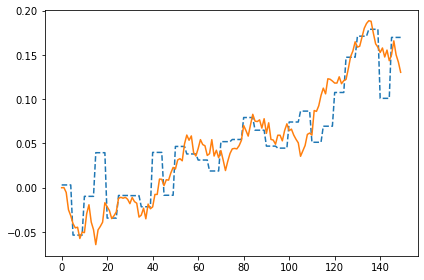

In [0]:
plt.plot(beta[:,0,:],linestyle = '--')
plt.plot(Beta[:,0])

plt.tight_layout()
